# Running models on the GPU

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/7.gpu-mnist.ipynb)

By [Terence Parr](https://explained.ai).


Let's redo the MNIST image classification example but this time run the network on a GPU.  The easiest way is just to click the icon there to run it at colab, and turn on the GPU runtime. (Go to "Change runtime type" under the runtime menu then select "GPU" under hardware accelerator; then select "Run all" under the runtime menu.) Or, you can still run it on your laptop/CPU; it'll just be slower.

(See [What Is the Difference Between a CPU and GPU?](https://www.intel.com/content/www/us/en/products/docs/processors/cpu-vs-gpu.html))

<img src="images/cpu-gpu.png" width="500"><br>Image credit: http://download.nvidia.com/developer/cuda/seminar/TDCI_Arch.pdf</font>.

Without going into too much detail, notice that both the CPU and GPU have access to their own memory (DRAM). Most importantly, the GPU has vastly more processing unit cores (green boxes) than the CPU, although the GPU processors are simpler and slower. When we say that vector operations occur in parallel, we mean that the various processors operate on different pieces of a large problem all at the same time. On a single processor, matrix and vector operations must iterate through all of the elements sequentially.

In order for a GPU to operate on data, we need to move it from main (CPU) memory to the GPU memory. Using the pytorch library, we do this by selecting a `torch.device` like `cuda:0` (first GPU) and then make sure that we use `.to(device)` on the tensor objects holding our data and the models that we create. Other than that, it's the same.

Now, sometimes we have to compute values and want them back on the CPU, which we can do by calling `.cpu()` on tensors that we know to be sitting on the GPU. 

The other thing to worry about is the auto gradient mechanism. If a tensor is involved in gradient computations, it's a part of the model, pytorch automatically tracks the gradient for all tensors used in the loss computation (so that we can perform gradient descent). That auto gradient computation graph can get quite large and if we need just the value, we call `.detach()` on the tensor. Furthermore, if we want that tensor on the CPU then we need to do `.detach().cpu()`. Use `.detach().cpu().numpy()` to get a numpy version of the tensor on the CPU.

Note: For whatever reason the AMD-based GPUs on Mac machines do not support CUDA, and so pytorch and many other libraries will not execute in parallel on your Mac's GPU. Booo!

## Support code

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

I find it convenient to ask the library to determine whether there is a CUDA (GPU from nvidia running the CUDA C-like language) device, and if not, set the device variable to the CPU:

In [2]:
# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Now, anytime I want to make sure that a tensor is on the appropriate computation engine, CPU or GPU, I can do something like the following:

```python
y = torch.tensor(y).to(device)
```

That does nothing if I'm running on the CPU but otherwise sends the data to the GPU. Here are my usual plotting routines:

In [3]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [4]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [5]:
X.shape

(10000, 784)

In [6]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

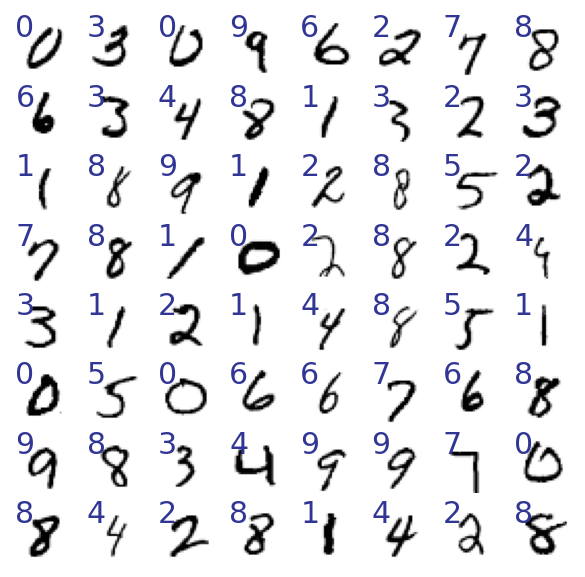

In [7]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

Now, let's create tensors from the X and y data; also indicate we want that data on the GPU, if one exists, by using `.to(device)`:

In [8]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training loop

The training loop for a $k$-class classifier is exactly the same as we saw in the previous notebook for MNIST classification. The only difference is that it will automatically perform computations on the GPU assuming the model and tensors that we pass it have been shifted to the GPU using `.to(device)`.

We create a model as before:

In [9]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

The big difference is that we now shift to the GPU, assuming we have one.

In [10]:
model = model.to(device) # make sure the model runs on the GPU as well

Training is the same:

In [11]:
def ctrain(model, X_train, y_train, X_test, y_test, 
           learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        # We definitely need to have auto gradient computed here
        loss = F.cross_entropy(y_pred, y_train)

        # This construct is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        # in this block of code
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [12]:
%%time
# On the CPU, this will take a very long time (about 20s) so
# use nepochs=1000 instead if you don't have a GPU. On a colab GPU,
# this same code takes about 2 seconds.
history = ctrain(model, X_train, y_train, X_test, y_test,
                 learning_rate = .03, nepochs=1000)

Epoch    0 cross entropy loss  2.3028   test loss  2.3028
Epoch  100 cross entropy loss  1.4848   test loss  1.5150
Epoch  200 cross entropy loss  1.4797   test loss  1.5096
Epoch  300 cross entropy loss  1.4780   test loss  1.5097
Epoch  400 cross entropy loss  1.4772   test loss  1.5094
Epoch  500 cross entropy loss  1.4772   test loss  1.5094
Epoch  600 cross entropy loss  1.4767   test loss  1.5085
Epoch  700 cross entropy loss  1.4764   test loss  1.5084
Epoch  800 cross entropy loss  1.4764   test loss  1.5082
Epoch  900 cross entropy loss  1.4763   test loss  1.5081
Epoch 1000 cross entropy loss  1.4756   test loss  1.5095
LAST        cross entropy loss  1.4756
CPU times: user 30.6 s, sys: 1.65 s, total: 32.2 s
Wall time: 26.6 s


In [13]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.985


In [14]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.953


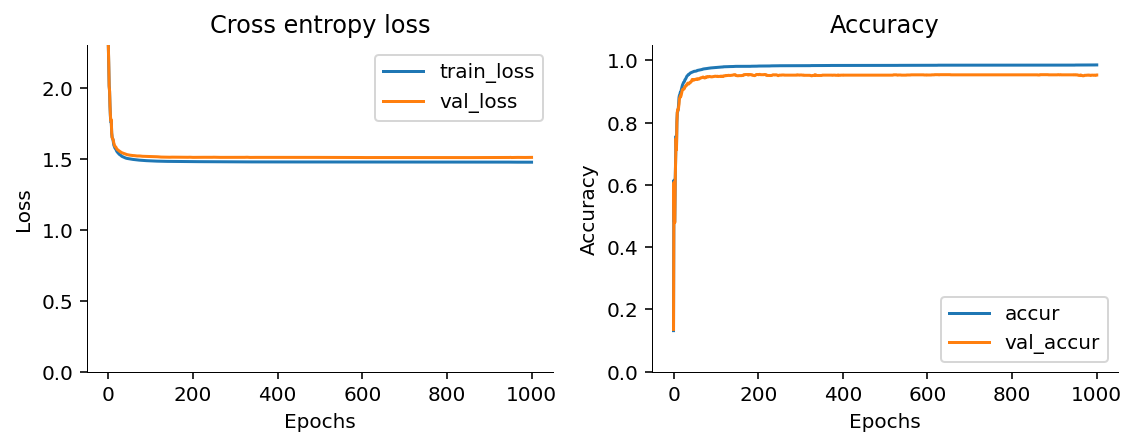

In [15]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()